# FastAI Audio
by @ste, @simonjhb, @zachcaceres

Wraps [torchaudio](https://github.com/pytorch/audio) to work with Audio within FastAI.

First, set up dependencies by uncommenting and running this cell.

If something goes wrong, try running it line by line in your terminal

In [1]:
# %%bash
# pip install pydub --user
# sudo apt-get install ffmpeg
# sudo apt-get install sox libsox-dev libsox-fmt-all
# git clone https://github.com/pytorch/audio.git torchaudio
# cd torchaudio
# python setup.py install
# %%

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *
import torch
from pdb import set_trace
from IPython.display import Audio
from pydub import AudioSegment, silence
import torchaudio
from torchaudio import transforms

## Dataset

YesNo is a tiny (4mb) dataset of people saying 'Yes' and 'No' in Hebrew. Each audio file is several seconds long, with a person saying a combination of 'yes' and 'no'.

In [4]:
# use dev_mode flag to tell torchaudio to keep raw audio files
yesno_data = torchaudio.datasets.YESNO('.', download=True, dev_mode=True)

Processing...
Found 60 audio files
Done!


In [5]:
PATH = Path('./yesno/raw/waves_yesno')
file_names = list(PATH.glob('*.wav'))
file_names[0]

PosixPath('yesno/raw/waves_yesno/1_0_0_0_0_0_1_1.wav')

In [6]:
# Sanity check a clip
sig,sr = torchaudio.load(file_names[0])
Audio(data=sig, rate=sr)

For this dataset, each file contains multiple examples of someone saying 'Yes' and 'No'.

Labels are in the file name. To make our lives easier, we'll split these longer clips into smaller clips with the labels extracted from the file name.

In [7]:
p = Path('.')/'processed_audio'
p.mkdir(exist_ok=True)

In [8]:
def process_sample(fn, parent_file):
    seg = AudioSegment.from_file(fn)
    # Use Pydub to split segment on silence, since samples have pauses between them.
    clips = silence.split_on_silence(seg, min_silence_len=100, silence_thresh=-32)
    
    # Extract labels from filenames like... 'yesno/raw/waves_yesno/1_0_0_0_0_0_1_1.wav'
    labels = str(fn).split('.')[0].split('/')[-1].split('_')
    for i,cl in enumerate(clips):
        cl.export(f'processed_audio/{parent_file}_{i}_{labels[i]}.wav', format="wav")

for i,fn in enumerate(file_names):
    process_sample(fn, i)

In [9]:
final_files = sorted(list(Path('./processed_audio').glob('*.wav')));
final_files[:5]

[PosixPath('processed_audio/0_0_1.wav'),
 PosixPath('processed_audio/0_1_0.wav'),
 PosixPath('processed_audio/0_2_0.wav'),
 PosixPath('processed_audio/0_3_0.wav'),
 PosixPath('processed_audio/0_4_0.wav')]

In [10]:
# Sanity check a split clip
sig,sr = torchaudio.load(final_files[0])
Audio(data=sig, rate=sr)

## Creating an Audio DataBlock

In [11]:
class AudioDataBunch(DataBunch):
    def hear_ex(self, rows:int=3, ds_type:DatasetType=DatasetType.Valid, **kwargs):
        batch = self.dl(ds_type).dataset[:rows]
        self.train_ds.hear_xys(batch.x, batch.y, **kwargs)

In [12]:
# These are valid file extensions for audio files
AUDIO_EXTENSIONS = set(k for k,v in mimetypes.types_map.items() if v.startswith('audio/'));

class AudioList(ItemList):
    _bunch = AudioDataBunch
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
            
    def get(self, i): return AudioItem.open(self.items[i])
    
    def reconstruct(self, t:Tensor): return Image(t.transpose(1,2))

    def hear_xys(self, xs, ys, **kwargs):
        for x, y in zip(xs, ys): x.hear(title=y, **kwargs)

    @classmethod
    def from_folder(cls, path:PathOrStr='.', extensions:Collection[str]=None, **kwargs)->ItemList:
        extensions = ifnone(extensions, AUDIO_EXTENSIONS)
        return super().from_folder(path=path, extensions=extensions, **kwargs)

In [43]:
class AudioItem(ItemBase):
    def __init__(self, fn, data=None, **kwargs):
        sig,sr = torchaudio.load(fn)
        self.fn = fn
        self.signal = sig
        self.data,self.sr,self.kwargs = data,sr,kwargs
        if self.data is None: self.data = transforms.MelSpectrogram(sr=sr, **kwargs)(self.signal)

    def __str__(self): return f'Duration: {self.duration} seconds. Source: {self.fn}'
    def __len__(self): return self.signal.shape[1]
    def _repr_html_(self): return f'{self.__str__()}<br />{self.ipy_audio._repr_html_()}'
    
    def show(self, ax:plt.Axes=None, figsize:tuple=(3,3), title:Optional[str]=None, hide_axis:bool=True,
              cmap:str=None, y:Any=None, **kwargs):
        "Show sound on `ax` with `title`, using `cmap` if single-channel, overlaid with optional `y`"
        self.hear(title=title)

    def hear(self, title=None):
        if title is not None: print(title)
        display(self.ipy_audio)

    def apply_tfms(self, tfms):
        for tfm in tfms:
            self.data = tfm(self.data)
        return self
        
    @property
    def shape(self):
        return self.data.shape

    @property
    def size(self)->Tuple[int,int]: return self.data.shape[-2:]

    @property
    def ipy_audio(self): return Audio(data=self.signal, rate=self.sr)

    @property
    def duration(self): return len(self)/self.sr

    @classmethod
    def open(cls, fn, **kwargs):
        return AudioItem(fn)

## Audio Transform

Our audio clips are different lengths. For computer vision we use padding to make sure our images are all the same size.

Even though our model will use images (spectrograms) to classify our data, we'll pad our audio directly. To do that, we need to find our longest clip and pad all smaller clips until they're the size.

In [14]:
def _pad_to_max(mx, value, t):
    """Pad tensor with `value` until it reaches length `mx`"""
    if t.shape[1] == mx: return t
    return F.pad(t, (0,0, 0,mx-t.shape[1]), value=value)

In [15]:
audios = AudioList.from_folder('./processed_audio')

# Get longest audio clip
max_len_of_audio = sorted([a.data.shape[1] for a in audios])[-1]

In [16]:
# Get a transform function that uses the max length of our audio list and pads with silence (0)
pad_to_max = partial(_pad_to_max, max_len_of_audio, 0)

In [17]:
# Regex to get the last digit in our file name (our label)
label_pattern = r'.*(\d).wav$'

# Normal datablock setup from our AudioList from above.
data = (audios
    .split_by_rand_pct(0.2)
    .label_from_re(label_pattern)
    .transform([[pad_to_max], [pad_to_max]])
    .databunch())

Let's hear a couple of examples from our databunch.

In [18]:
data.hear_ex()

1


0


1


In [19]:
# AudioItem offers some nice helpers to check our audio in more detail
data.x[1]

AudioItem Duration: 0.435 seconds. Source: processed_audio/29_2_1.wav

## Model

We'll classify our images using Resnet18. Resnet expects a 3 channel input (RGB values for an image).

Our data has only 1 channel. So we'll replace the first layer of our ResNet with custom layer that's identical except it accepts 1 channel input.

In [20]:
newlayer = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
newlayer.cuda() # Our layer should use cuda, since the rest of the model will.
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [21]:
# Replace our first layer
learn.model[0][0] = newlayer

In [22]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.744168,0.754269,0.505263,00:01
1,0.597893,0.524194,0.768421,00:00
2,0.487523,0.619601,0.726316,00:00
3,0.407935,0.574604,0.757895,00:00
4,0.354459,0.494650,0.789474,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


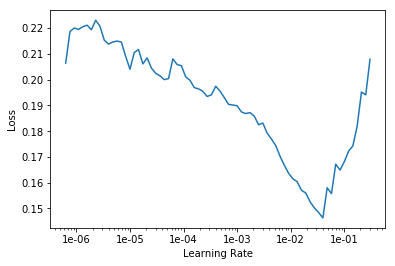

In [23]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.259534,0.496486,0.852632,00:00
1,0.225542,1.763740,0.842105,00:00
2,0.278296,1.048173,0.863158,00:00
3,0.342118,2.748038,0.800000,00:00
4,0.419248,1.670059,0.800000,00:00
5,0.354998,1.763417,0.821053,00:00
6,0.335410,1.300600,0.852632,00:00
7,0.296331,1.065315,0.873684,00:00
8,0.250456,0.494108,0.915789,00:00
9,0.222678,0.375390,0.936842,00:00


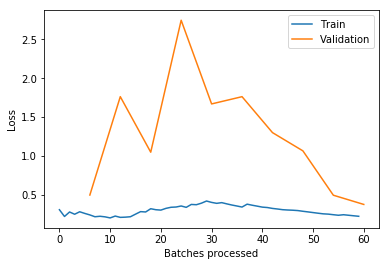

In [24]:
learn.fit_one_cycle(10, max_lr=slice(1e-03,9e-02))
learn.recorder.plot_losses()

## Interpretation

In [55]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

Let's hide the graphs provided by .plot_top_losses since they don't help us. Our AudioItem class will let us make sensible comparisons between clips.

1/0 / 10.06 / 0.00


1/0 / 8.16 / 0.00


0/1 / 7.47 / 0.00


1/0 / 4.29 / 0.01


1/0 / 3.45 / 0.03


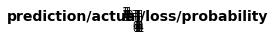

In [57]:
interp.plot_top_losses(5, figsize=(0.1,0.1))

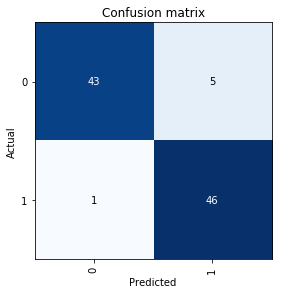

In [58]:
interp.plot_confusion_matrix()